In [338]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage import filters, morphology
from skimage import feature
from skimage.morphology import disk, dilation, erosion
from skimage.segmentation import watershed
import cv2
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans

In [339]:
# Loading the MATLAB file
mat_data = scipy.io.loadmat('Brain.mat')
# Extracting MRI data
mri_dataT1 = mat_data['T1']  
mri_data.shape

(362, 434, 10)

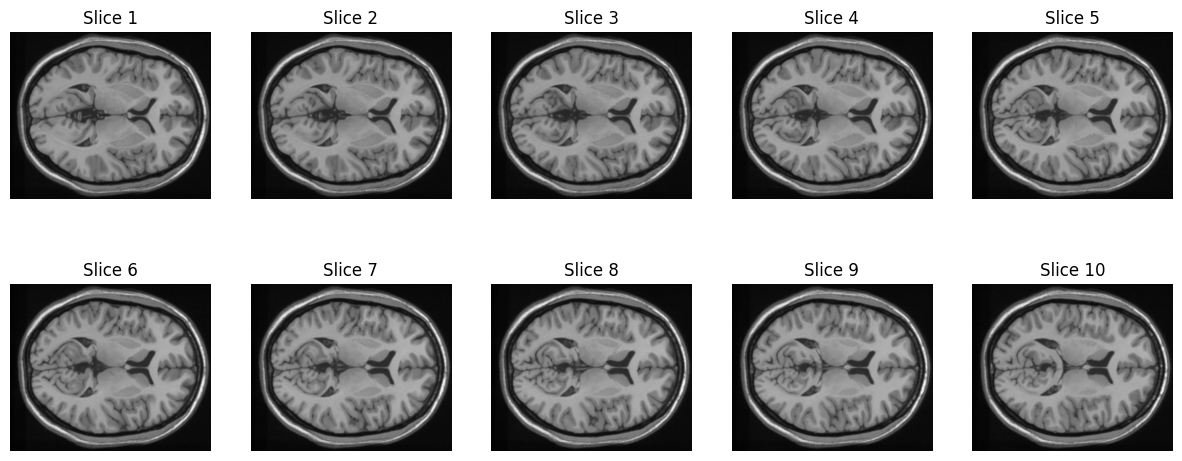

In [340]:
# Displaying the 10 slice 
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(mri_dataT1[:, :, i], cmap='grey')
    ax.axis('off')
    ax.set_title(f"Slice {i+1}")
plt.show()

In [341]:
#loading MRI label data
mat_data = scipy.io.loadmat('Brain.mat')

# Extracting MRI label data
mri_datalabel = mat_data['label']  
mri_data.shape

(362, 434, 10)

In [347]:
#taking all the label data in np array
all_ground_truth_masks = []

for i in range(10):
    all_ground_truth_masks.append(mri_datalabel[:,:,i])

all_ground_truth_masks = np.array(all_ground_truth_masks)

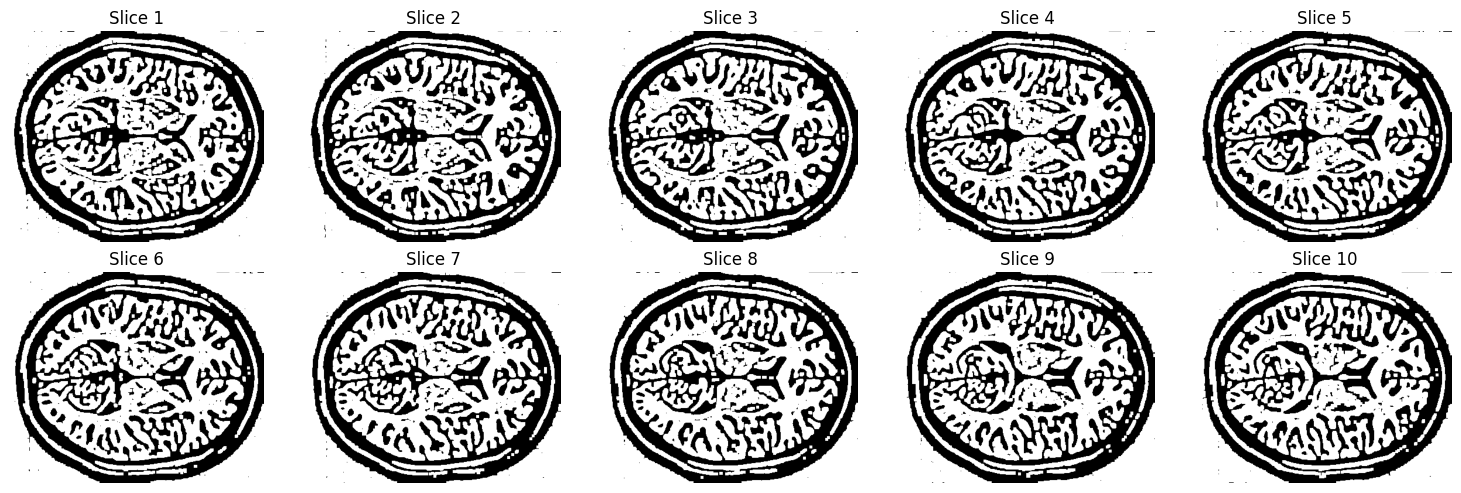

In [303]:
# Applying adaptive threshold
mri_data_uint8 = (mri_dataT1 / np.max(mri_dataT1) * 255).astype(np.uint8)
#subplot
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
# Applying adaptive thresholding to each slice
for i in range(10):
    original_img = mri_data_uint8[:, :, i]
    threshold_img = cv2.adaptiveThreshold(original_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 3)
    # Applying erosion and dilation
    kernel = np.ones((3, 3), np.uint8)
    eroded_img = cv2.erode(threshold_img, kernel, iterations=2)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=2)
    # Ploting labeled regions
    ax = axs[i // 5, i % 5]
    ax.imshow(dilated_img, cmap='grey')
    ax.set_title(f"Slice {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()


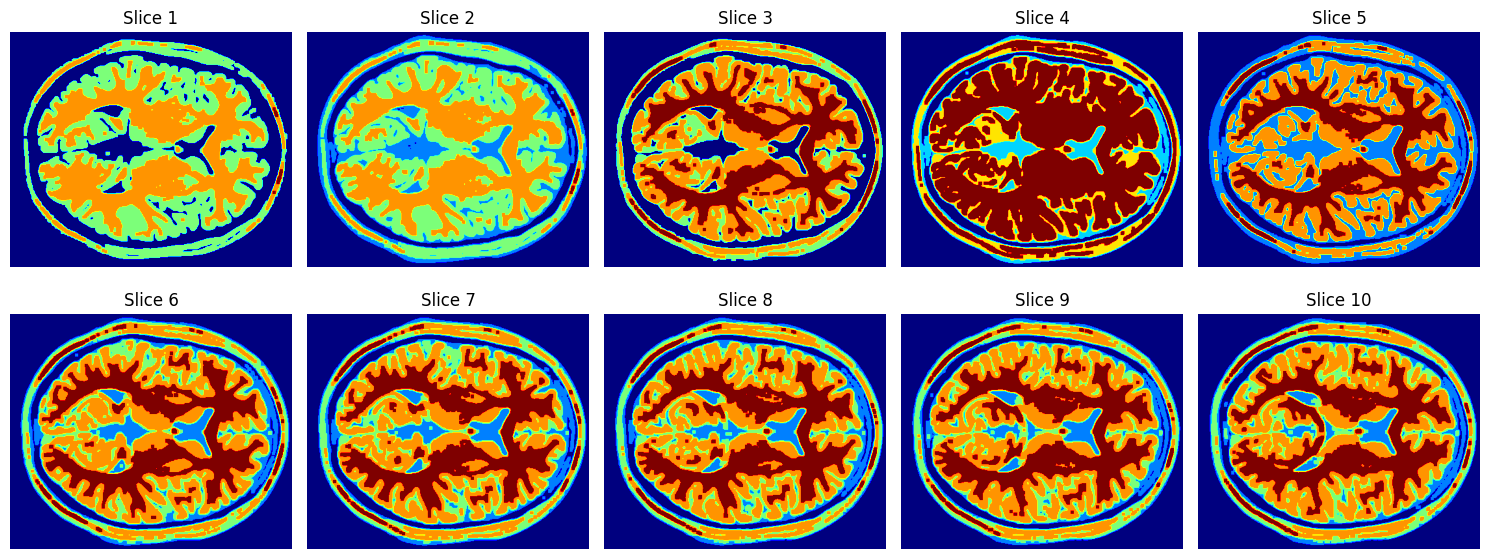

In [316]:
#Applying combination of Multiotsu and kmeans clustering
num_slices = mri_dataT1.shape[2]
otsuAndClustering = []
# Creating subplots 
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# Applying multiOtsu thresholding to each slice
for i in range(num_slices):
    mri_slice = mri_dataT1[:, :, i]
    thresholds = threshold_multiotsu(mri_slice, classes = 5)
    segmented_img = np.digitize(mri_slice, bins=thresholds)
    #then applying kmeans clustering
    img = segmented_img.reshape((-1,1))
    img = np.float32(img)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k=5
    ret, label, center = cv2.kmeans(img,k,None,criteria,10,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((segmented_img.shape))
    # Applying erosion and dilation
    kernel = np.ones((3, 3), np.uint8)
    eroded_img = cv2.erode(res2.astype(np.uint8), kernel, iterations=2)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=2)
    # Ploting segmented image
    ax = axs[i // 5, i % 5]
    ax.imshow(dilated_img, cmap='jet')
    ax.set_title(f"Slice {i+1}")
    ax.axis('off')
    #storing all the images in a np array 
    otsuAndClustering.append(dilated_img)
otsuAndClustering = np.array(otsuAndClustering)
plt.tight_layout()
plt.show()

In [305]:
#Evaluating using dice coefficient with the ground truth
def dice_coefficient(otsuAndClustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5):
    # Binarizing the segmented mask and gt_mask using the threshold
    seg_mask_binary = (otsuAndClustering > seg_threshold).astype(np.uint8)
    gt_mask_binary = (all_ground_truth_masks > gt_threshold).astype(np.uint8)
    seg_flat = seg_mask_binary.flatten()
    gt_flat = gt_mask_binary.flatten()
    # Calculating intersection and union
    intersection = np.sum(seg_flat * gt_flat)
    union = np.sum(seg_flat) + np.sum(gt_flat)
    # Calculating Dice coefficient
    dice = (2.0 * intersection) / (union + 1e-8)
    return dice
segmented_masks_array = np.array(otsuAndClustering)
ground_truth_masks_array = np.array(all_ground_truth_masks)
# Calculating Dice coefficient for each pair of segmented and ground truth masks
dice_scores = []
for otsuAndClustering, all_ground_truth_masks in zip(segmented_masks_array, ground_truth_masks_array):
    dice_score = dice_coefficient(otsuAndClustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5)
    dice_scores.append(dice_score)
# Calculating average Dice coefficient
average_dice = np.mean(dice_scores)
print("Average Dice coefficient:", average_dice)

Average Dice coefficient: 0.9428574051614668


In [318]:
#Evaluating using Pixel accuracy with the ground truth
def pixel_accuracy(otsuAndClustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5):
    # Binarizing the segmented mask and gt_mask using the threshold
    seg_mask_binary = (otsuAndClustering > seg_threshold).astype(np.uint8)
    gt_mask_binary = (all_ground_truth_masks > gt_threshold).astype(np.uint8)
    correct_pixels = np.sum(seg_mask_binary == gt_mask_binary)
    total_pixels = seg_mask_binary.size
    # Calculating pixel accuracy
    accuracy = correct_pixels / total_pixels
    return accuracy
segmented_masks_array = np.array(otsuAndClustering)
ground_truth_masks_array = np.array(all_ground_truth_masks)
pixel_accuracies = []
for otsuAndClustering, all_ground_truth_masks in zip(segmented_masks_array, ground_truth_masks_array):
    accuracy = pixel_accuracy(otsuAndClustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5)
    pixel_accuracies.append(accuracy)
average_accuracy = np.mean(pixel_accuracies)
print("Average Pixel Accuracy:", average_accuracy)

Average Pixel Accuracy: 0.8109962573516308


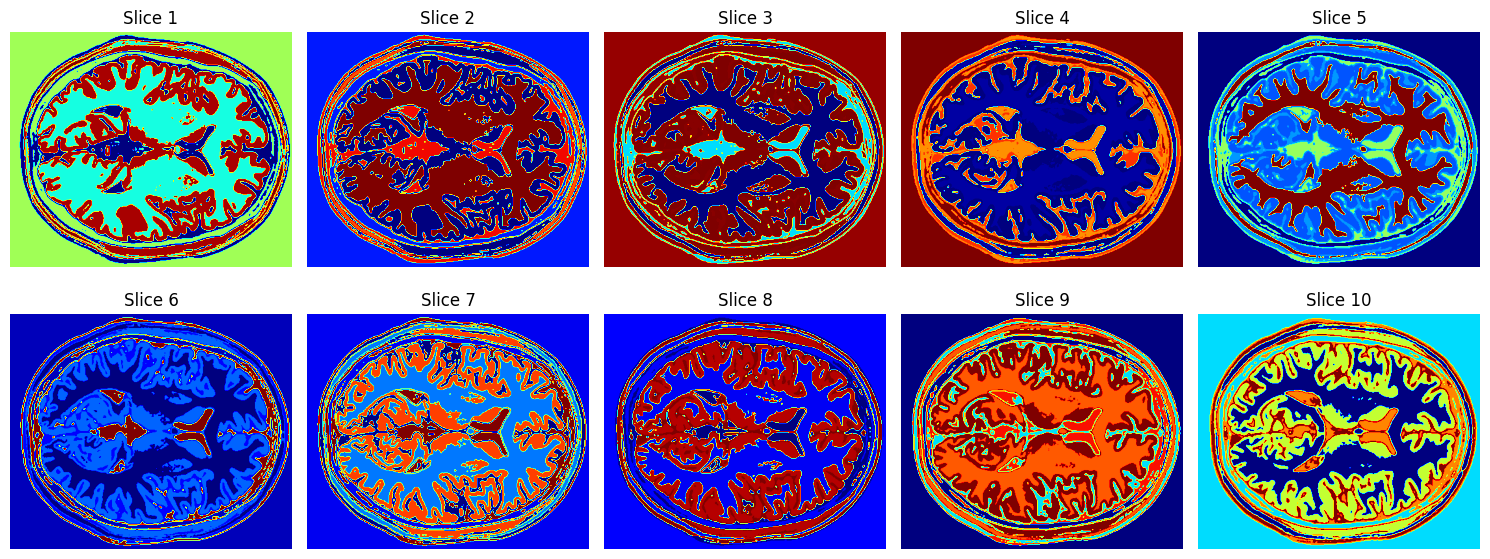

In [320]:
#Applying KMeans clustering
num_slices = mri_dataT1.shape[2]
clustering = []
# Creating subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(num_slices):
    img = mri_dataT1[:,:,i].reshape((-1,1))
    img = np.float32(img)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k=5
    ret, label, center = cv2.kmeans(img,k,None,criteria,10,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((mri_dataT1[:,:,i].shape))
    # Plotting segmented image
    ax = axs[i // 5, i % 5]
    ax.imshow(res2, cmap='jet')
    ax.set_title(f"Slice {i+1}")
    ax.axis('off')
    #storing segmented images in a np array
    clustering.append(res2)
clustering = np.array(clustering)
plt.tight_layout()
plt.show()

In [314]:
#Evaluating kmeans approach using dice coefficient with the ground truth
def dice_coefficient(clustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5):
    seg_mask_binary = (clustering > seg_threshold).astype(np.uint8)
    gt_mask_binary = (all_ground_truth_masks > gt_threshold).astype(np.uint8)
    seg_flat = seg_mask_binary.flatten()
    gt_flat = gt_mask_binary.flatten()
    intersection = np.sum(seg_flat * gt_flat)
    union = np.sum(seg_flat) + np.sum(gt_flat)
    dice = (2.0 * intersection) / (union + 1e-8)  
    return dice
segmented_masks_array = np.array(clustering)  
ground_truth_masks_array = np.array(all_ground_truth_masks) 
dice_scores = []
for clustering, all_ground_truth_masks in zip(segmented_masks_array, ground_truth_masks_array):
    dice_score = dice_coefficient(clustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5)
    dice_scores.append(dice_score)
average_dice = np.mean(dice_scores)
print("Average Dice coefficient:", average_dice)

Average Dice coefficient: 0.8372143179425511


In [321]:
#Evaluating kmeans approach using Pixel accuracy with the ground truth
def pixel_accuracy(clustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5):
    seg_mask_binary = (clustering > seg_threshold).astype(np.uint8)
    gt_mask_binary = (all_ground_truth_masks > gt_threshold).astype(np.uint8)
    correct_pixels = np.sum(seg_mask_binary == gt_mask_binary)
    total_pixels = seg_mask_binary.size
    accuracy = correct_pixels / total_pixels
    return accuracy
segmented_masks_array = np.array(clustering) 
ground_truth_masks_array = np.array(all_ground_truth_masks)  
pixel_accuracies = []
for clustering, all_ground_truth_masks in zip(segmented_masks_array, ground_truth_masks_array):
    accuracy = pixel_accuracy(clustering, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5)
    pixel_accuracies.append(accuracy)
average_accuracy = np.mean(pixel_accuracies)
print("Average Pixel Accuracy:", average_accuracy)

Average Pixel Accuracy: 0.7282442650915294


10


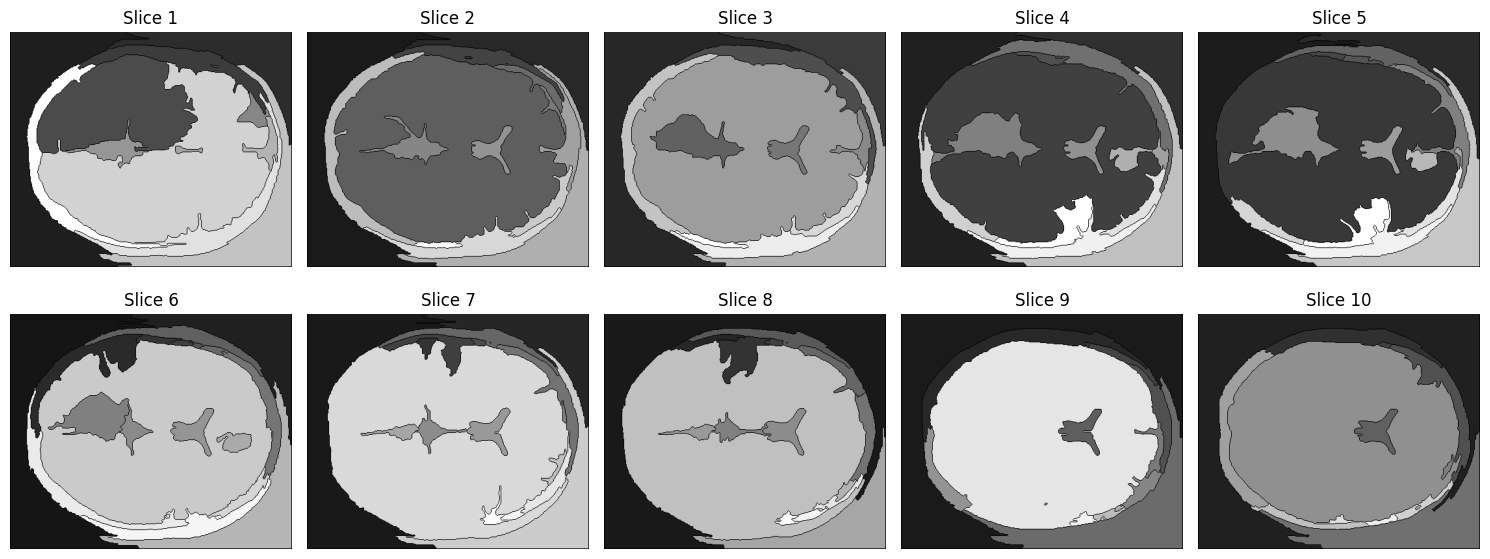

In [348]:
#Advanced image segmentation (Watershed)
num_slices = mri_data.shape[2]
print(num_slices)
watershedApproach = []
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(num_slices):
    img = mri_data[:,:,i]
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    imgRGB = np.uint8(imgRGB)
    # Appling Gaussian blur to smooth the image
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    #thresholding
    _,imgthreshold = cv2.threshold(blur,120,255,cv2.THRESH_BINARY_INV)
    # Defining the kernel
    kernel = np.ones((3,3), np.uint8)
    # Applying morphological operation
    imageDilate = cv2.morphologyEx(imgthreshold, cv2.MORPH_OPEN, kernel)
    #calculating distance
    imageDilate = cv2.convertScaleAbs(imageDilate)
    disTrans = cv2.distanceTransform(imageDilate,cv2.DIST_L2,5)
    _,disThresh = cv2.threshold(disTrans,15,255,cv2.THRESH_BINARY)
    disThresh = np.uint8(disThresh)
    _,labels = cv2.connectedComponents(disThresh)
    labels = np.int32(labels)
    labels = cv2.watershed(imgRGB,labels)
    ax = axs[i // 5, i % 5]
    ax.imshow(labels, cmap='grey')
    ax.set_title(f"Slice {i+1}")
    ax.axis('off')
    #storing all the images in a np array
    watershedApproach.append(labels)
watershedApproach = np.array(watershedApproach)
plt.tight_layout()
plt.show()

In [345]:
#Evaluating watershed approach with ground truth using dice coefficient
def dice_coefficient(watershedApproach, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5):
    seg_mask_binary = (watershedApproach > seg_threshold).astype(np.uint8)
    gt_mask_binary = (all_ground_truth_masks > gt_threshold).astype(np.uint8)
    seg_flat = seg_mask_binary.flatten()
    gt_flat = gt_mask_binary.flatten()
    intersection = np.sum(seg_flat * gt_flat)
    union = np.sum(seg_flat) + np.sum(gt_flat)
    dice = (2.0 * intersection) / (union + 1e-8) 
    return dice
segmented_masks_array = np.array(watershedApproach) 
ground_truth_masks_array = np.array(all_ground_truth_masks) 
dice_scores = []
for watershedApproach, all_ground_truth_masks in zip(segmented_masks_array, ground_truth_masks_array):
    dice_score = dice_coefficient(watershedApproach, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5)
    dice_scores.append(dice_score)
average_dice = np.mean(dice_scores)
print("Average Dice coefficient:", average_dice)

Average Dice coefficient: 0.8323619558964431


In [349]:
#Evaluating watershe approach with ground truth using pixel accuracy metric
def pixel_accuracy(watershedApproach, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5):
    seg_mask_binary = (watershedApproach > seg_threshold).astype(np.uint8)
    gt_mask_binary = (all_ground_truth_masks > gt_threshold).astype(np.uint8)
    #comparing segemented mask and ground truth mask
    correct_pixels = np.sum(seg_mask_binary == gt_mask_binary)
    total_pixels = seg_mask_binary.size
    accuracy = correct_pixels / total_pixels
    return accuracy
segmented_masks_array = np.array(watershedApproach)  
ground_truth_masks_array = np.array(all_ground_truth_masks) 
pixel_accuracies = []
for watershedApproach, all_ground_truth_masks in zip(segmented_masks_array, ground_truth_masks_array)
    accuracy = pixel_accuracy(watershedApproach, all_ground_truth_masks, seg_threshold=0.5, gt_threshold=0.5)
    pixel_accuracies.append(accuracy)
average_accuracy = np.mean(pixel_accuracies)
print("Average Pixel Accuracy:", average_accuracy)

Average Pixel Accuracy: 0.715987091682155
